# Crossvalidation experiments with KuHar as base and KuHar as target

This notebook will perform crossvalidation experiments using the KuHar dataset at 20 Hz as training dataset. It will contain the following steps:

1. Quick load train, test and validation CSV subsets from the balanced KuHar dataset at 20 Hz using `KuHar_BalancedView20HzMotionSenseEquivalent` helper
2. Quick load train, test and validation CSV subsets from other relevant datasets using `KuHar_BalancedView20HzMotionSenseEquivalent` helper
3. Subclassing the `Dataset` interface using `PandasMultiModalDataset`
4. Apply the fourier transform and umap on KuHar
5. Train SVM, KNN and Random Forest classification models on the KuHar dataset in the frequency domain
6. Evaluate SVM, KNN and Random Forest classification models on KuHar in the frequency domain

The experiments will evaluate the performance of SVM, KNN and RF models trained on a balanced KuHar dataset and tested on KuHar in the frequency domains reduced with umap to 10 dimensions.

## Common imports and definitions

In [1]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package

# This must be done if librep is not installed via pip,
# as this directory (examples) is appart from librep package root
sys.path.append("../../../..")

In [2]:
# Third party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.manifold import TSNE
from umap import UMAP

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.multimodal import PandasMultiModalDataset, TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler
from librep.datasets.har.loaders import (
    KuHar_BalancedView20HzMotionSenseEquivalent,
    MotionSense_BalancedView20HZ,
    ExtraSensorySense_UnbalancedView20HZ,
    CHARM_BalancedView20Hz,
    WISDM_UnbalancedView20Hz,
    UCIHAR_UnbalancedView20Hz
)

2022-11-11 20:47:44.045971: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-11 20:47:44.045990: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
labels_activity = {
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run",
    6: "stair up and down",
}

## Loading data from base dataset
Change the path here to use in other dataset as base

In [4]:
# Load KuHar
loader = KuHar_BalancedView20HzMotionSenseEquivalent("../../../../data/views/KuHar/balanced_20Hz_motionsense_equivalent-v1", 
                              download=False)
train_validation_base, test_target = loader.load(concat_train_validation=True, label="standard activity code")
train_validation_base, test_target

(PandasMultiModalDataset: samples=3114, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=246, features=360, no. window=6, label_columns='standard activity code')

Let's take a look in the train dataframes

In [5]:
train_validation_base.data

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,accel-start-time,gyro-start-time,accel-end-time,gyro-end-time,activity code,length,serial,index,user,standard activity code
0,-1.042828,7.069610,3.455672,0.858443,-13.806092,-5.950121,-0.608514,2.916913,4.881929,8.610287,...,9.159,9.160,12.199,12.201,0,300,23,900,1101,4
1,-2.437900,-2.628449,-2.166861,-3.854701,0.527599,11.567884,6.840191,-2.435600,-3.324599,-0.796095,...,9.167,9.166,12.211,12.208,0,300,43,900,1101,4
2,-0.664337,0.483465,3.090238,3.559119,3.888318,1.113559,3.656104,4.866379,0.073993,-14.136122,...,15.262,15.263,18.298,18.299,0,300,24,1500,1101,4
3,-2.269775,-3.209509,-2.508545,-2.923223,-1.269270,7.864898,7.683389,2.325797,-3.086381,-3.675483,...,33.572,33.583,36.615,36.626,0,300,41,3300,1101,4
4,-0.487718,0.226401,0.609332,1.490074,-0.295221,-1.111420,-0.627382,0.028419,-0.823724,-0.469242,...,0.008,0.007,3.047,3.048,0,300,30,0,1101,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,-16.047706,-10.232285,-1.393564,22.982999,13.706479,7.789294,-4.720361,-15.633462,-8.674399,-11.634360,...,3.000,3.007,6.000,6.008,5,300,8,300,1042,5
3110,1.911780,-6.910686,1.625745,12.975344,12.066726,5.300426,-10.848059,-14.261385,-3.988711,-4.235381,...,5.927,5.927,8.880,8.879,5,300,2,600,1046,5
3111,3.927244,19.311380,0.403673,-14.236972,-10.454149,-4.218160,-4.307016,17.655546,12.570647,7.031853,...,2.966,2.966,5.920,5.919,5,300,5,300,1046,5
3112,-7.208894,-11.734247,13.677432,21.571222,3.191808,2.215446,-12.397302,-13.905091,-8.743007,11.580156,...,3.003,3.001,5.993,5.991,5,300,6,300,1042,5


## Fourier Transform

In [6]:
#fft_transform = FFT(centered = True)
fft_transform = FFT(centered=True)

transformer_fft = TransformMultiModalDataset(transforms=[fft_transform], 
                                         new_window_name_prefix="reduced.")

umap = UMAP(n_components=10, random_state=42)
train_validation_base_fft = transformer_fft(train_validation_base)

umap.fit(train_validation_base_fft[:][0])

umap_transform = WindowedTransform(
    transform=umap, fit_on=None, transform_on="all"
)

transformer = TransformMultiModalDataset(transforms=[fft_transform, umap_transform], 
                                         new_window_name_prefix="reduced.")

### Use FFT and UMAP in the base dataset

In [7]:
train_validation_base_fft = transformer(train_validation_base)

In [8]:
train_validation_base[:][0]

array([[ -1.04282825,   7.06961015,   3.45567162, ...,   0.50890319,
         -0.11305444,  -0.38018973],
       [ -2.43790048,  -2.62844861,  -2.16686063, ...,  -0.09413675,
         -0.23829967,   0.3772596 ],
       [ -0.66433712,   0.48346468,   3.09023849, ...,   0.28845053,
          0.11892508,   0.28859494],
       ...,
       [  3.92724394,  19.31137994,   0.4036726 , ...,   0.92610044,
          1.03635366,  -0.09064377],
       [ -7.20889409, -11.73424672,  13.67743163, ...,  -0.13913523,
          0.74242743,   0.76542017],
       [ -1.30519969,   0.77625489,  -2.01040912, ...,   0.53948006,
          1.16119165,  -0.4627136 ]])

In [9]:
train_validation_base_fft[:][0]

array([[-1.3282369 , 10.576902  ,  7.79454   , ...,  4.7765117 ,
         6.9144044 ,  7.116663  ],
       [-1.3556559 , 10.59557   ,  7.845233  , ...,  4.7850437 ,
         6.895278  ,  7.1166277 ],
       [-1.036034  , 10.521475  ,  8.832548  , ...,  4.6840487 ,
         7.237176  ,  6.9307075 ],
       ...,
       [-0.5652612 ,  9.94024   , -0.2961723 , ...,  5.0399466 ,
         5.9510264 ,  6.6860647 ],
       [-0.805875  ,  9.696256  , -1.136654  , ...,  5.3587265 ,
         5.6676407 ,  6.4887033 ],
       [-0.5538428 ,  9.656432  , -0.82273906, ...,  5.100598  ,
         5.8670297 ,  6.494375  ]], dtype=float32)

In [10]:
test_target_fft = transformer(test_target)

In [11]:
test_target[:][0]

array([[-1.81754657, -0.84484186, -3.42024083, ..., -0.47886246,
        -0.25724051, -1.22396785],
       [ 8.30047265, -1.27743412,  5.48006221, ..., -0.34679287,
        -0.64192185,  0.46023301],
       [-0.19802598, -1.10536453, -2.08157882, ...,  0.40917228,
         0.39153061, -0.15666666],
       ...,
       [ 2.14782272, -2.31485654, -0.81952774, ...,  0.93662894,
         0.52192419,  0.85651806],
       [-8.01534249,  2.34830125,  0.95563646, ...,  1.32309685,
        -2.0783611 , -2.05310751],
       [-2.63105618,  1.07232495, -0.86048054, ...,  1.27507948,
         0.3014468 ,  0.99273025]])

In [12]:
test_target_fft[:][0]

array([[-0.98994404, 10.336817  ,  7.189003  , ...,  4.5133886 ,
         7.4120746 ,  6.963647  ],
       [-1.1020763 , 10.2593355 ,  7.5165205 , ...,  4.4924183 ,
         8.087417  ,  6.9576917 ],
       [-0.9986126 , 10.2456045 ,  7.098572  , ...,  4.5276985 ,
         7.696862  ,  6.9617233 ],
       ...,
       [-0.5952922 ,  9.900162  ,  0.88548833, ...,  5.017025  ,
         6.197215  ,  6.6638794 ],
       [-0.99775547, 10.380707  ,  7.1228647 , ...,  4.5243917 ,
         7.2223835 ,  6.997535  ],
       [-0.6836099 ,  9.846879  ,  0.75479597, ...,  4.9932203 ,
         6.1570745 ,  6.669448  ]], dtype=float32)

## Train and evaluate Random Forest classifier

In [13]:
standard_activity_codes = {
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run"
    # 6: "stair up and down"
}
labels = list(standard_activity_codes.values())
print(labels, '\n\n', standard_activity_codes)

['sit', 'stand', 'walk', 'stair up', 'stair down', 'run'] 

 {0: 'sit', 1: 'stand', 2: 'walk', 3: 'stair up', 4: 'stair down', 5: 'run'}


In [14]:
# The reporter will be the same

reporter = ClassificationReport(
    use_accuracy=True,
    use_f1_score=True,
    use_classification_report=True,
    use_confusion_matrix=True,
    plot_confusion_matrix=True,
    # normalize='true',
    display_labels=labels,
)

experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier, 
    estimator_creation_kwags ={'n_estimators':100}, 
    do_not_instantiate=False, 
    do_fit=True, 
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

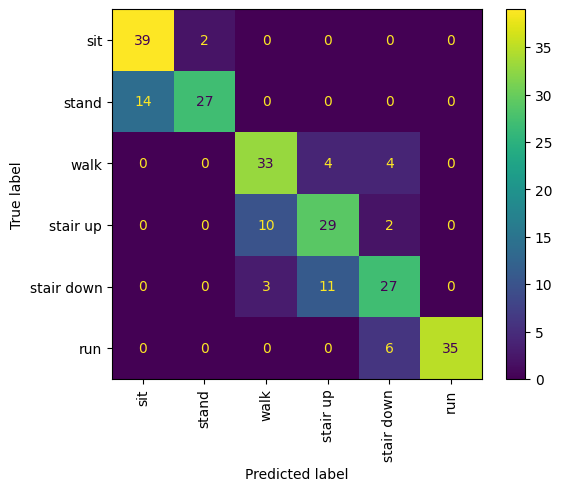

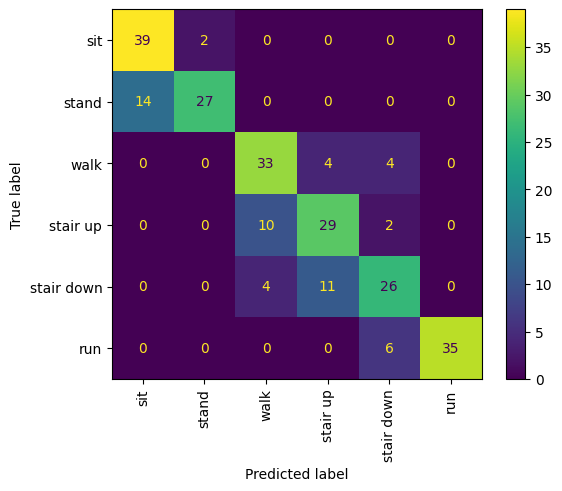

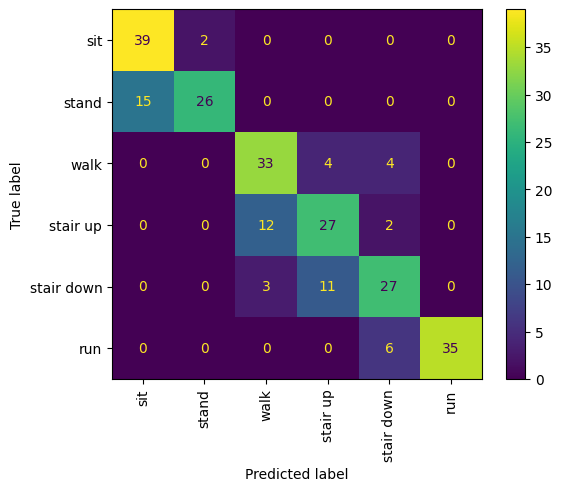

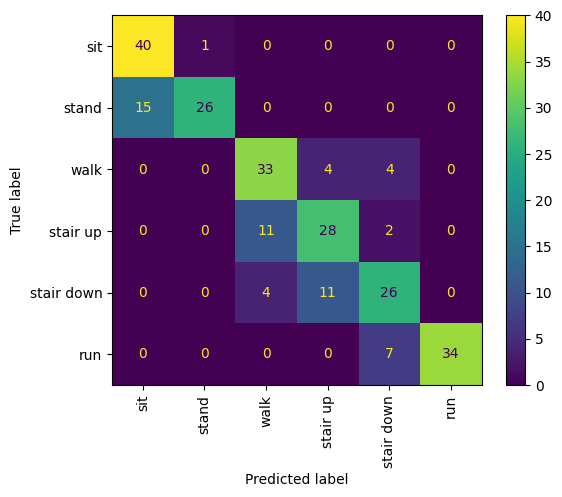

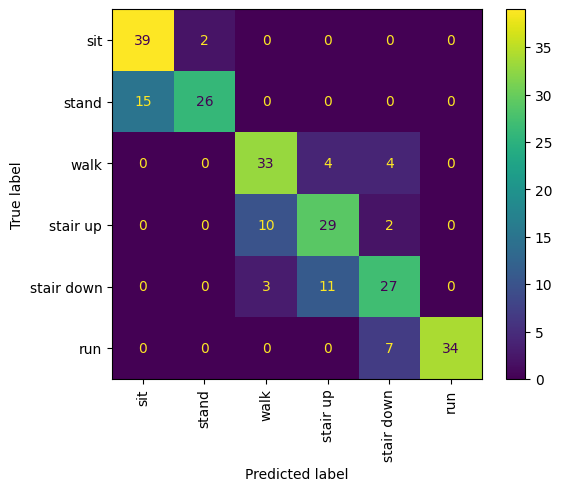

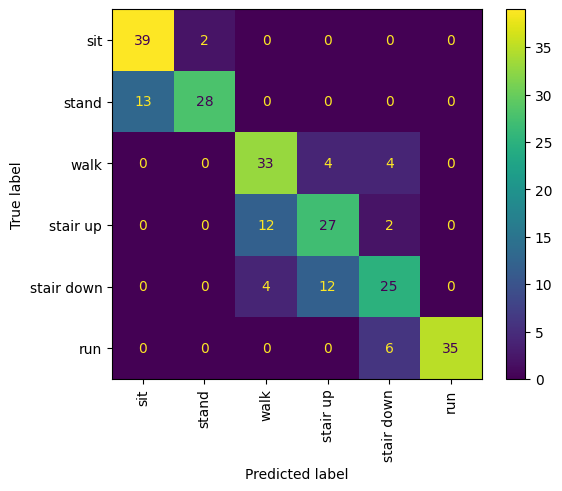

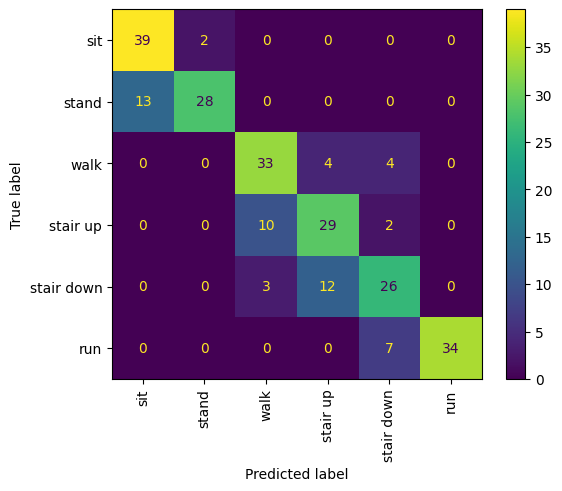

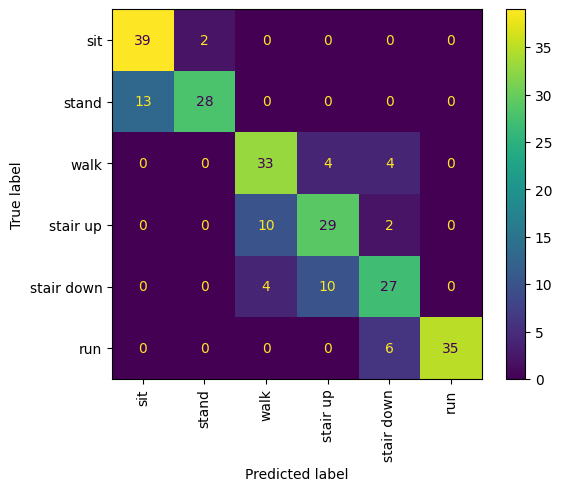

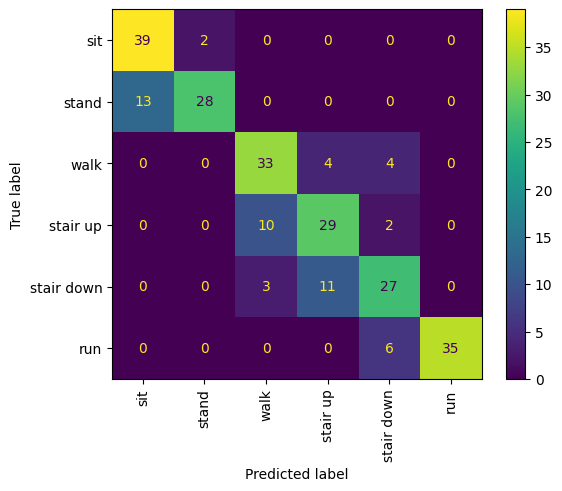

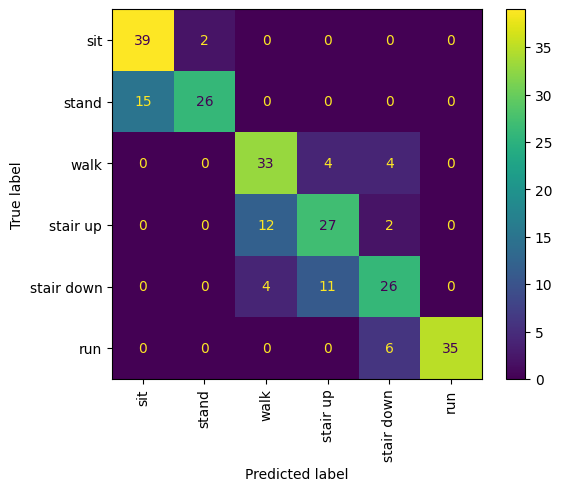

Mean accuracy (10 runs): 0.7663. Mean f1-score: 0.7669
Standard deviation accuracy (10 runs): 0.0069. Standard deviation f1-score: 0.0071


In [17]:
results = multi_run_experiment(train_validation_base_fft, test_target_fft)

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)

mean_f1_per_class = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)

print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

In [18]:
metrics = ['precision', 'recall', 'f1-score', 'support']
mean_f1_per_class = { 
    activity: 
    {
        metric : np.mean([ res['result'][0]['classification report'][str(activity)][metric] 
        for res in results["runs"] ])
        for metric in metrics
        for res in results["runs"]
        
    }
    for activity in list(labels_activity.keys())[:6]
}
mean_f1_per_class

{0: {'precision': 0.736563750714694,
  'recall': 0.9536585365853659,
  'f1-score': 0.8310904405832702,
  'support': 41.0},
 1: {'precision': 0.9344079547527823,
  'recall': 0.6585365853658536,
  'f1-score': 0.7723362167892265,
  'support': 41.0},
 2: {'precision': 0.6995759312050444,
  'recall': 0.8048780487804879,
  'f1-score': 0.7484295492703088,
  'support': 41.0},
 3: {'precision': 0.652001073861539,
  'recall': 0.6902439024390243,
  'f1-score': 0.6705035188634154,
  'support': 41.0},
 4: {'precision': 0.6821660830871358,
  'recall': 0.6439024390243901,
  'f1-score': 0.6624148003894839,
  'support': 41.0},
 5: {'precision': 1.0,
  'recall': 0.8463414634146341,
  'f1-score': 0.9167368421052631,
  'support': 41.0}}

## Train and evaluate Support Vector Machine classifier

In [19]:
experiment = SimpleTrainEvalWorkflow(estimator=SVC, estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} , 
                                     do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

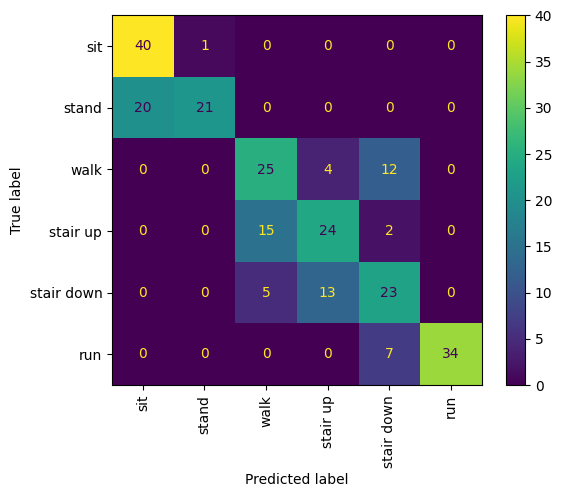

Mean accuracy (10 runs): 0.6789. Mean f1-score: 0.6789
Standard deviation accuracy (10 runs): 0.0000. Standard deviation f1-score: 0.0000


In [20]:
results = multi_run_experiment(train_validation_base_fft, test_target_fft)

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

In [21]:
metrics = ['precision', 'recall', 'f1-score', 'support']
mean_f1_per_class = { 
    activity: 
    {
        metric : np.mean([res['result'][0]['classification report'][str(activity)][metric] 
        for res in results["runs"] ])
        for metric in metrics
        for res in results["runs"]
        
    }
    for activity in list(labels_activity.keys())[:6]
}
mean_f1_per_class

{0: {'precision': 0.6666666666666666,
  'recall': 0.975609756097561,
  'f1-score': 0.7920792079207921,
  'support': 41.0},
 1: {'precision': 0.9545454545454546,
  'recall': 0.5121951219512195,
  'f1-score': 0.6666666666666667,
  'support': 41.0},
 2: {'precision': 0.5555555555555556,
  'recall': 0.6097560975609756,
  'f1-score': 0.5813953488372093,
  'support': 41.0},
 3: {'precision': 0.5853658536585366,
  'recall': 0.5853658536585366,
  'f1-score': 0.5853658536585366,
  'support': 41.0},
 4: {'precision': 0.5227272727272727,
  'recall': 0.5609756097560976,
  'f1-score': 0.5411764705882354,
  'support': 41.0},
 5: {'precision': 1.0,
  'recall': 0.8292682926829268,
  'f1-score': 0.9066666666666667,
  'support': 41.0}}

In [25]:
results["runs"][0]['result']#[0]['classification report']

[{'accuracy': 0.6788617886178862,
  'f1 score (weighted)': 0.6788917023896845,
  'f1 score (micro)': 0.6788617886178862,
  'f1 score (macro)': 0.6788917023896847,
  'confusion matrix': [[40, 1, 0, 0, 0, 0],
   [20, 21, 0, 0, 0, 0],
   [0, 0, 25, 4, 12, 0],
   [0, 0, 15, 24, 2, 0],
   [0, 0, 5, 13, 23, 0],
   [0, 0, 0, 0, 7, 34]],
  'classification report': {'0': {'precision': 0.6666666666666666,
    'recall': 0.975609756097561,
    'f1-score': 0.7920792079207921,
    'support': 41},
   '1': {'precision': 0.9545454545454546,
    'recall': 0.5121951219512195,
    'f1-score': 0.6666666666666667,
    'support': 41},
   '2': {'precision': 0.5555555555555556,
    'recall': 0.6097560975609756,
    'f1-score': 0.5813953488372093,
    'support': 41},
   '3': {'precision': 0.5853658536585366,
    'recall': 0.5853658536585366,
    'f1-score': 0.5853658536585366,
    'support': 41},
   '4': {'precision': 0.5227272727272727,
    'recall': 0.5609756097560976,
    'f1-score': 0.5411764705882354,
    

## Train and evaluate K Neighbors Classifier classifier

In [22]:
experiment = SimpleTrainEvalWorkflow(estimator=KNeighborsClassifier, estimator_creation_kwags=
                                     {'n_neighbors' :1} , do_not_instantiate=False, do_fit=True, 
                                     evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

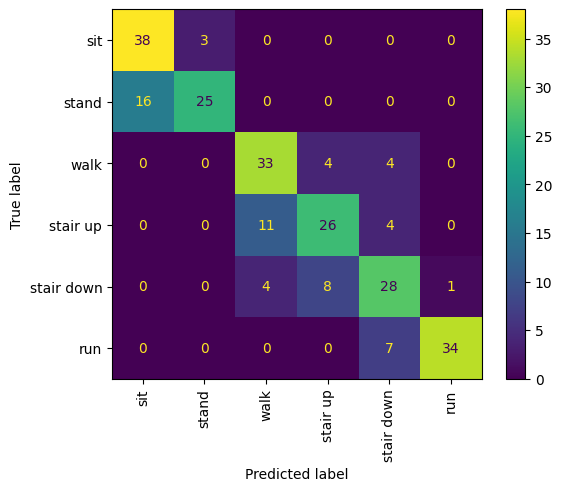

Mean accuracy (10 runs): 0.7480. Mean f1-score: 0.7476
Standard deviation accuracy (10 runs): 0.0000. Standard deviation f1-score: 0.0000


In [21]:
results = multi_run_experiment(train_validation_base_fft, test_target_fft)

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

In [22]:
metrics = ['precision', 'recall', 'f1-score', 'support']
mean_f1_per_class = { 
    activity: 
    {
        metric : np.mean([ res['result'][0]['classification report'][str(activity)][metric] 
        for res in results["runs"] ])
        for metric in metrics
        for res in results["runs"]
        
    }
    for activity in list(labels_activity.keys())[:6]
}
mean_f1_per_class

{0: {'precision': 0.7037037037037037,
  'recall': 0.926829268292683,
  'f1-score': 0.8000000000000002,
  'support': 41.0},
 1: {'precision': 0.8928571428571429,
  'recall': 0.6097560975609756,
  'f1-score': 0.7246376811594203,
  'support': 41.0},
 2: {'precision': 0.6875,
  'recall': 0.8048780487804879,
  'f1-score': 0.7415730337078651,
  'support': 41.0},
 3: {'precision': 0.6842105263157895,
  'recall': 0.6341463414634146,
  'f1-score': 0.6582278481012659,
  'support': 41.0},
 4: {'precision': 0.6511627906976745,
  'recall': 0.6829268292682927,
  'f1-score': 0.6666666666666667,
  'support': 41.0},
 5: {'precision': 0.9714285714285714,
  'recall': 0.8292682926829268,
  'f1-score': 0.8947368421052632,
  'support': 41.0}}